In [1]:
import numpy as np
import os
import time
from keras.preprocessing.image import load_img, img_to_array
#from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from scipy import misc,ndimage
from matplotlib import pyplot
#import helpers as Helper


from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split


model = VGG16(include_top=True,weights="imagenet")


Using TensorFlow backend.
/home/jimmy/anaconda3/envs/curso/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:


print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
# Loading the training data
PATH = os.getcwd()
# Define data path
data_path = PATH + '/data'
validation_path = PATH + '/validation_data'
data_dir_list = os.listdir(data_path)
classes = ['shovel','edger','hammer']
target_size=(224,224)
batch_size=10


def pre_process_image_before_appending(image):
    img = load_img(img_path, target_size=(224, 224))
#     pyplot.imshow(img)
#     pyplot.show()
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def createGenerator():
    gen = ImageDataGenerator(rescale=1./255)
    #classes = list(['shovel','edger','hammer'])
    batches = gen.flow_from_directory(
        classes=list(classes),
        directory=data_path, 
        target_size=target_size, 
        class_mode='categorical', 
        color_mode="rgb", 
        batch_size=batch_size,
        seed=42)
    #x_batch, y_batch = next(batches)
    return batches

def createValidationGenerator():
    datagen_val = ImageDataGenerator(rescale=1./255)
    val_generator = datagen_val.flow_from_directory(
        directory= validation_path,
        classes=list(classes),
        target_size=target_size,
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True,
        seed=42
    )
    return val_generator


In [5]:

image_input = Input(shape=(224, 224, 3))

model = VGG16( include_top=False, weights='imagenet')
#model.summary()
last_layer = model(image_input) #model.get_layer('fc2').output

x= Flatten(name='flatten')(last_layer)
x = Dense(4096, activation='relu', name='fc5')(x)
x = Dense(4096, activation='relu', name='fc6')(x)
out = Dense(len(classes), activation='softmax', name='predictions')(x)
custom_vgg_model = Model(image_input, out)

#Train all but the last layer
print(custom_vgg_model.layers[3].trainable)


# for layer in custom_vgg_model.layers[:-1]:
# 	layer.trainable = False

custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
    
#print(custom_vgg_model.layers[3].trainable)

custom_vgg_model.summary()

train_generator = createGenerator()
val_generator = createValidationGenerator()
idx_2_class = {v:k for k,v in train_generator.class_indices.items()}

custom_vgg_model.fit_generator(
        train_generator,
        steps_per_epoch=8,
        epochs=10,
        validation_data=val_generator)

# t=time.time()
#	t = now()
# hist = custom_vgg_model.fit(X_train, y_train, batch_size=32, epochs=2, verbose=1, validation_data=(X_test, y_test))
# print('Training time: %s' % (t - time.time()))
# (loss, accuracy) = custom_vgg_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

# print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))
        

# model = VGG16(include_top=False,weights="imagenet")
# print(model.summary())

True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc5 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
fc6 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 3)                 12291     
Total params: 134,272,835
Trainable params: 134,272,835
Non-trainable params: 0
_________________________________________________________

('clase:', 'hammer')


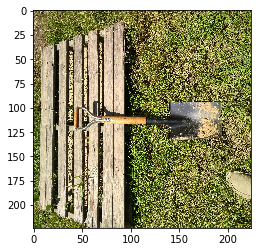

('clase:', 'hammer')


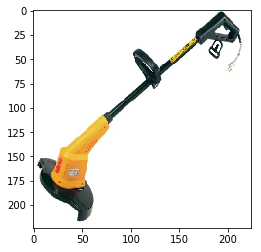

('clase:', 'hammer')


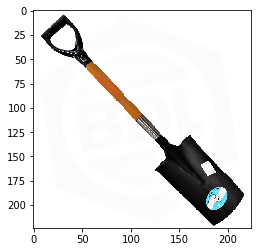

('clase:', 'hammer')


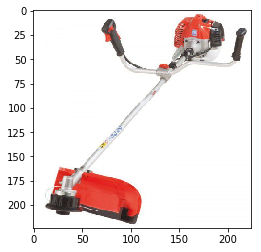

('clase:', 'hammer')


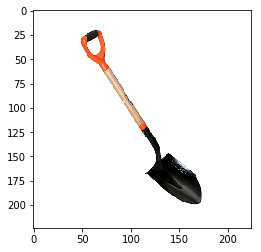

('clase:', 'hammer')


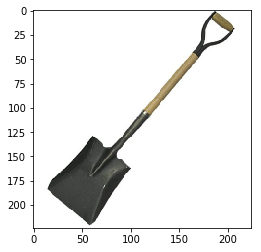

('clase:', 'hammer')


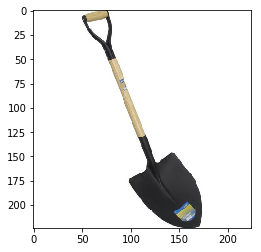

('clase:', 'hammer')


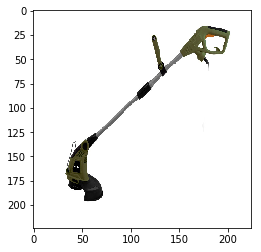

('clase:', 'hammer')


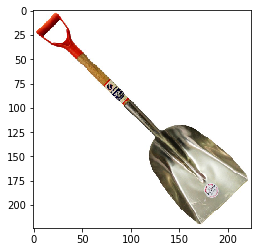

('clase:', 'hammer')


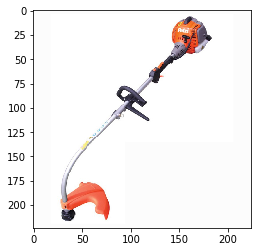

('clase:', 'hammer')


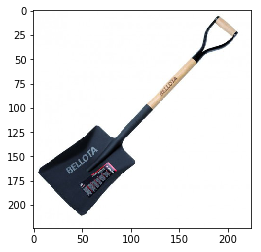

('clase:', 'hammer')


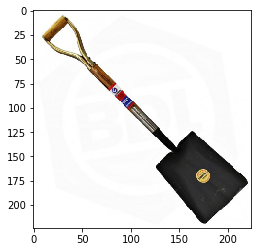

('clase:', 'hammer')


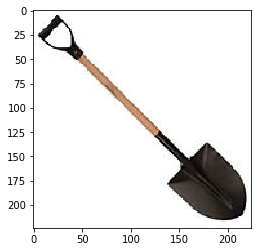

array([[0., 0., 1.]], dtype=float32)

In [9]:
for i in range(len(val_generator)):
    images, class_true = next(val_generator)
    class_pred = custom_vgg_model.predict_on_batch(images)
    indexes = np.logical_not((np.argmax(class_pred, axis = 1) == np.argmax(class_true, axis=1)))
    for i, image in enumerate(images[indexes]):
        class_idx = np.argmax(class_pred, axis = 1)[indexes][i]
        class_id = idx_2_class[class_idx]
        print('clase:', class_id)
        pyplot.imshow(image)
        pyplot.show()
img = load_img('test_pala.jpg', target_size=(224, 224))
img = img_to_array(img)

img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))

img = preprocess_input(img)
# predict the probability across all output classes

custom_vgg_model.predict(img)

In [44]:
#Training the feature extraction also

# image_input = Input(shape=(224, 224, 3))

# model = VGG16(input_tensor=image_input, include_top=False,weights='imagenet')

# model.summary()

# last_layer = model.get_layer('block5_pool').output
# x= Flatten(name='flatten')(last_layer)
# x = Dense(512, activation='relu', name='fc1')(x)
# x = Dropout(0.1)(x)
# x = Dense(512, activation='relu', name='fc2')(x)
# x = Dense(128, activation='relu', name='fc3')(x)
# x = Dropout(0.1)(x)
# x = Dense(128, activation='relu', name='fc4')(x)
# out = Dense(len(classes), activation='softmax', name='output')(x)
# custom_vgg_model2 = Model(image_input, out)
# custom_vgg_model2.summary()

# # freeze all the layers except the dense layers
# for layer in custom_vgg_model2.layers[:-3]:
# 	layer.trainable = False

# custom_vgg_model2.summary()

# custom_vgg_model2.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

# train_generator = createGenerator()
# val_generator = createValidationGenerator()
# idx_2_class = {v:k for k,v in train_generator.class_indices.items()}

# custom_vgg_model.fit_generator(
#         train_generator,
#         #steps_per_epoch=steps_per_epoch,
#         epochs=15,
#         validation_data=val_generator)

# t=time.time()
# #	t = now()
# hist = custom_vgg_model2.fit(X_train, y_train, batch_size=8, epochs=12, verbose=1, validation_data=(X_test, y_test))
# print('Training time: %s' % (t - time.time()))
# (loss, accuracy) = custom_vgg_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)

# print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

IOError: [Errno 21] Is a directory: '/home/jimmy/Curso_ML/jugando/validation_data'

In [45]:
# import matplotlib.pyplot as plt
# # visualizing losses and accuracy
# train_loss=hist.history['loss']
# val_loss=hist.history['val_loss']
# train_acc=hist.history['acc']
# val_acc=hist.history['val_acc']
# xc=range(12)

# plt.figure(1,figsize=(7,5))
# plt.plot(xc,train_loss)
# plt.plot(xc,val_loss)
# plt.xlabel('num of Epochs')
# plt.ylabel('loss')
# plt.title('train_loss vs val_loss')
# plt.grid(True)
# plt.legend(['train','val'])
# #print plt.style.available # use bmh, classic,ggplot for big pictures
# plt.style.use(['classic'])

# plt.figure(2,figsize=(7,5))
# plt.plot(xc,train_acc)
# plt.plot(xc,val_acc)
# plt.xlabel('num of Epochs')
# plt.ylabel('accuracy')
# plt.title('train_acc vs val_acc')
# plt.grid(True)
# plt.legend(['train','val'],loc=4)
# #print plt.style.available # use bmh, classic,ggplot for big pictures
# plt.style.use(['classic'])

NameError: name 'hist' is not defined

In [20]:
# image = load_img('bordeadora.jpg', target_size=(224, 224))
# image = img_to_array(image)
# #image = np.expand_dims(image,axis=0)
# image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# image = preprocess_input(image)
# # predict the probability across all output classes
# custom_vgg_model2.predict(image)

# # convert the probabilities to class labels
# #label = decode_predictions(yhat)
# # retrieve the most likely result, e.g. highest probability
# #label = label[0][0]
# # print the classification
# #print('%s (%.2f%%)' % (label[1], label[2]*100))

array([[0.13286819, 0.03374255, 0.8333893 ]], dtype=float32)